In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from config import technologies

In [2]:
df = pd.read_csv("./djinni/vacancies.csv", encoding="utf-8")
df.head(3)

,title,company,salary,category,publicated,description
0,Python Developer в IT академію STUDY SPACE,Study.ua,NaN,"Категорія: Python,Англійська: Intermediate,2 р...","Вакансія опублікована 6 березня 2023,8 перегля...",Додаткова part-time робота для Python Develope...
1,Python Developer (with Terraform experience),Binariks,NaN,"Категорія: Python,Англійська: Upper-Intermedia...","Вакансія опублікована 6 березня 2023,16 перегл...",Healthcare project about the healing power of ...
2,Middle Strong/Senior Python Engineer,Geniusee,NaN,"Категорія: Python,Англійська: Intermediate,5 р...","Вакансія опублікована 6 березня 2023,12 перегл...","Geniusee looking for remote a,with 4+ years of..."


In [3]:
df["experience"] = pd.Series([cat.split(",")[-1] for cat in df["category"]])
df["language"] = [
    cat.split(",")[1] if len(cat.split(",")) == 3 else None for cat in df["category"]
]
df["category"] = pd.Series([cat.split(",")[0] for cat in df["category"]])

In [4]:
df["view"] = pd.Series([cat.split(",")[1].split(" ")[0] for cat in df["publicated"]])
df["review"] = pd.Series([cat.split(",")[2].split(" ")[0] for cat in df["publicated"]])
df["review"] = df.review.astype("int")
df["publicated"] = pd.Series(
    [" ".join(cat.split(",")[0].split(" ")[2:]) for cat in df["publicated"]]
)

#  1. Technology popularity

In [5]:
tech = set([tech.lower() for tech in technologies])
df["descript"] = pd.Series(
    re.findall("[a-zA-Z]+", desc.lower()) for desc in df["description"]
)
df["technologies"] = pd.Series(
    ",".join(tech.intersection(set(desc))) for desc in df["descript"]
)
df = df.reindex(
    columns=[
        "title",
        "company",
        "salary",
        "technologies",
        "experience",
        "language",
        "publicated",
        "view",
        "review",
        "description",
        "descript",
        "category"
    ]
)
df.head(3)

,title,company,salary,technologies,experience,language,publicated,view,review,description,descript,category
0,Python Developer в IT академію STUDY SPACE,Study.ua,NaN,"aws,sql,python,git,linux,docker",2 роки досвіду,Англійська: Intermediate,6 березня 2023,8,0,Додаткова part-time робота для Python Develope...,"[part, time, python, developer, study, space, ...",Категорія: Python
1,Python Developer (with Terraform experience),Binariks,NaN,"docker,aws,django,python",2 роки досвіду,Англійська: Upper-Intermediate,6 березня 2023,16,3,Healthcare project about the healing power of ...,"[healthcare, project, about, the, healing, pow...",Категорія: Python
2,Middle Strong/Senior Python Engineer,Geniusee,NaN,"aws,flask,ai,python,fastapi,django,docker,api",5 років досвіду,Англійська: Intermediate,6 березня 2023,12,3,"Geniusee looking for remote a,with 4+ years of...","[geniusee, looking, for, remote, a, with, year...",Категорія: Python


In [6]:
tech_ll = [tt for tt in df["technologies"]]
tech_ll.remove("")
tech_list = ",".join(tech_ll).split(",")
tech_set = list(set(tech_list))
tech_series = pd.Series(tech_list, name="tech")

In [7]:
tf = tech_series.to_frame()
tf_count = tf.groupby(by="tech")["tech"].count().to_frame(name="number")
tf_count.sort_values(by="number", ascending=False, inplace=True)

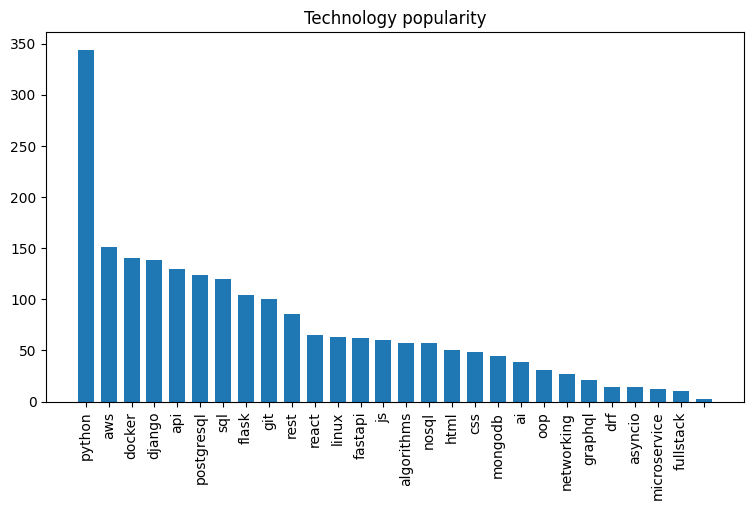

In [18]:
number = tf_count["number"].to_list()
technologies = tf_count.index.to_list()
fig, ax = plt.subplots()
fig.set_figwidth(9)
ax.bar(technologies, number, width=0.7)
ax.set_title("Technology popularity")
plt.xticks(rotation=90)
plt.show()

# 2.    A vacancies for developers level

In [9]:
dflev = pd.DataFrame(index=df.index)
dflev["level"] = pd.Series([re.findall("[a-zA-Z]+", str(s).lower()) for s in df.title])
for i in range(dflev.shape[0]):
    for ll in dflev.loc[i]:
        flag = True
        for w in ll:
            if w in ("junior", "middle", "senior"):
                dflev.loc[i] = w
                flag = False
        if flag:
            dflev.loc[i] = "none level"
level = dflev.groupby("level")["level"].count().sort_values(ascending=False)
level

level
none level    154
senior        139
middle         55
junior         11
Name: level, dtype: int64

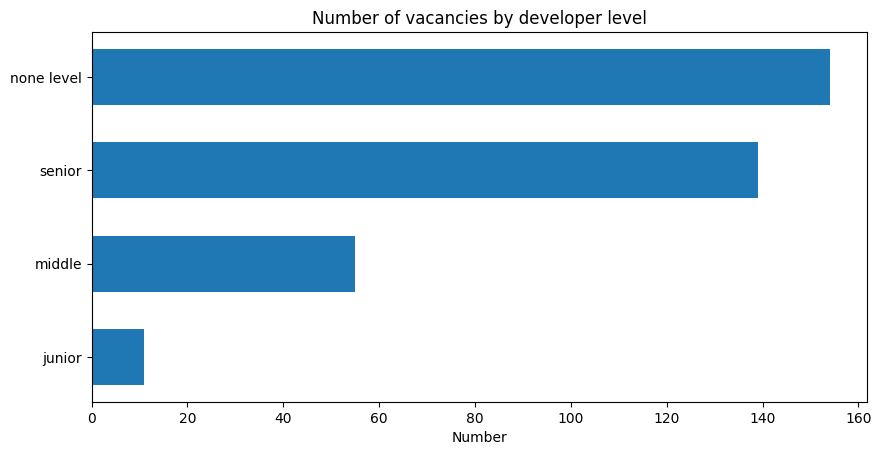

In [17]:
x_level = level.index
y_count = level.values
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.barh(x_level, y_count, height=0.6)
ax.invert_yaxis()
ax.set_xlabel("Number")
ax.set_title("Number of vacancies by developer level")
plt.show()

#  3.  A vacancies by experience

In [11]:
tech_ll = [tt for tt in df["technologies"]]
tech_ll.remove("")
tech_list = ",".join(tech_ll).split(",")
tech_set = list(set(tech_list))
tech_series = pd.Series(tech_list, name="tech")
tf = tech_series.to_frame()
tf_count = tf.groupby(by="tech")["tech"].count().to_frame(name="number")
tf_count.sort_values(by="number", ascending=False, inplace=True)

In [12]:
dfl = pd.DataFrame(index=df.index)
dfl["title"] = df["title"]
dfl["experience"] = df["experience"]
dfl.head(3)

,title,experience
0,Python Developer в IT академію STUDY SPACE,2 роки досвіду
1,Python Developer (with Terraform experience),2 роки досвіду
2,Middle Strong/Senior Python Engineer,5 років досвіду


(-1.1, 1.1, -1.1, 1.1)

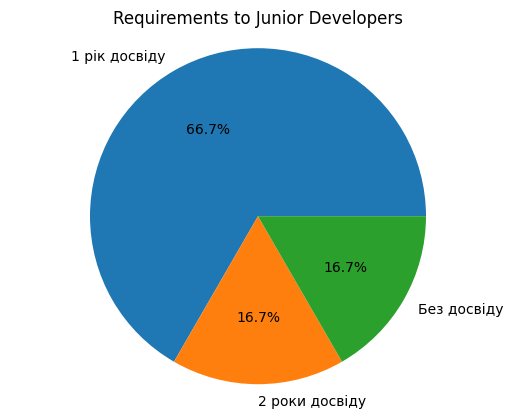

In [13]:
df_junior = dfl[dfl["title"].str.contains("unior")]
df_experience = (
    df_junior.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()
fig, ax = plt.subplots()
ax.set_title("Requirements to Junior Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.0999999196735828,
 1.0999999961749325,
 -1.0999999467245365,
 1.099998881215266)

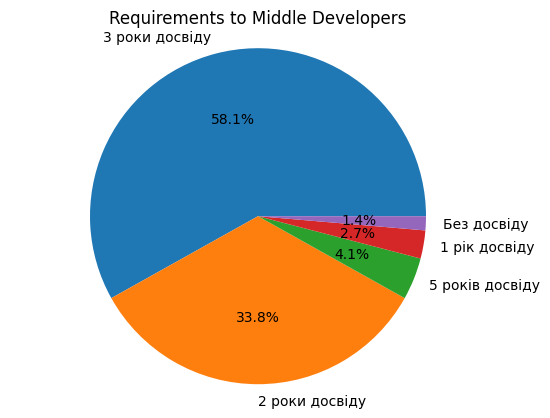

In [19]:
df_middle = dfl[dfl["title"].str.contains("iddle")]
df_experience = (
    df_middle.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to Middle Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.0999985028119568,
 1.0999999287053313,
 -1.0999950887028973,
 1.0999989572520543)

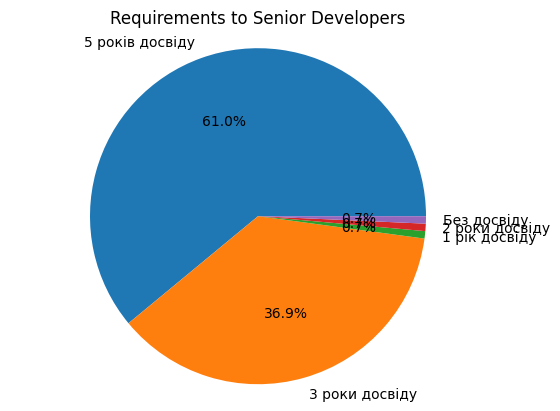

In [20]:
df_senior = dfl[dfl["title"].str.contains("enior")]
df_experience = (
    df_senior.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to Senior Developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")

(-1.0999999992173435,
 1.0999999999627306,
 -1.0999966184704923,
 1.0999913892035982)

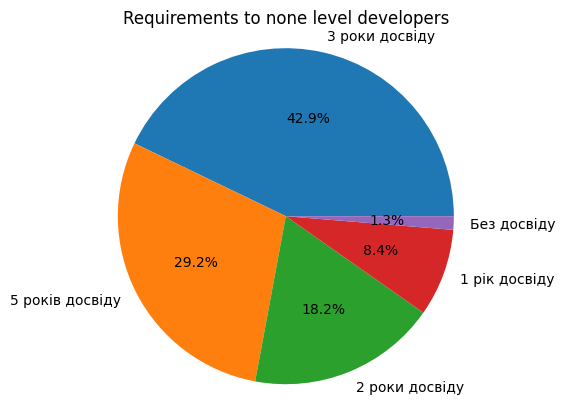

In [21]:
df_notlevel = dfl[
    ~dfl["title"].str.contains("unior")
    & ~dfl["title"].str.contains("iddle")
    & ~dfl["title"].str.contains("enior")
]
df_notlevel.head(10)
df_experience = (
    df_notlevel.groupby(["experience"])["experience"]
    .count()
    .nlargest(10, keep="first")
    .rename("count")
)
vals = df_experience.to_list()
labels = df_experience.index.to_list()

fig, ax = plt.subplots()
ax.set_title("Requirements to none level developers")
ax.pie(vals, labels=labels, autopct="%1.1f%%")
ax.axis("equal")